<a href="https://colab.research.google.com/github/jmbrown89/phenotypy/blob/master/Hackathon_at_Harwell%2C_Oxfordshire_H2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon at Harwell, Oxfordshire: H2O


# Dataset download

The dataset is publicly available at https://cbmm.mit.edu/mouse-dataset. For more information about how the dataset was created, please refer to the original publication by Jhuang et al (2010): https://www.nature.com/articles/ncomms1064.

The following cells will download the "clipped database" and unzip it. Alternatively, you can host the data yourself on Google Drive and mount it.

In [4]:
!wget -q --show-progress https://www.dropbox.com/s/8scxzzao1d55j7q/clipped_database.zip?dl=1 -O clipped_database.zip

clipped_database.zi 100%[===================>]   1000M  18.3MB/s    in 56s     


In [6]:
!unzip -oq clipped_database.zip

# Loading clips

The class below is provided to simplify the process of loading the video data. When instantiated, a `Clip` object will attempt to open the video at the specified file path to retrieve its metadata and ground truth label.

To grab the actual frames (and label), use the following code:

```
c = Clip(clip_path)  # opens file for reading
frames, label = c.get_data()  # returns clip as numpy array
c.close()  # closes the file
```

In [1]:
%matplotlib inline
import cv2
(major_ver, minor_ver, subminor_ver) = cv2.__version__.split('.')
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# these are the eight behaviours we want to classify
LABELS = ["drink", "eat", "groom", "hang", "micromovement", "rear", "rest", "walk"]

# the label notation is quite inconsistent - this standardises across them
LABEL_MAPPING = {
    "d": "drink",
    "e": "eat",
    "groomback": "groom",
    "gb": "groom",
    "g": "groom",
    "ha": "hang",
    "hang": "hang",
    "head": "micromovement",
    "he": "micromovement",
    "r": "rear",
    "rs": "rest",
    "w": "walk"
}

class Clip:

    def __init__(self, file_path):

        self.file_path = Path(file_path)
        self.video = None
        self.frames = None
        self.fps = self.width = self.height = self.length = self.channels = 0

        label = self.file_path.name.split("_")[-2]
        if label not in LABELS:
            self.label = LABEL_MAPPING[label]
        else:
            self.label = label

        self._load()

    def _load(self):

        if not self.file_path.exists():
            raise FileNotFoundError(f"Video file '{self.file_path}' does not exist!")

        video = cv2.VideoCapture(str(self.file_path))
        self.video = video
        self.fps = video.get(cv2.CV_CAP_PROP_FPS) if int(major_ver) < 3 else self.video.get(cv2.CAP_PROP_FPS)
        self.width = int(video.get(cv2.CV_CAP_PROP_FRAME_WIDTH)) if int(major_ver) < 3 else int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(video.get(cv2.CV_CAP_PROP_FRAME_HEIGHT)) if int(major_ver) < 3 else int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.length = int(video.get(cv2.CV_CAP_PROP_FRAME_COUNT)) if int(major_ver) < 3 else int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        frame = None
        attempts = 0
        while frame is None and attempts < 10:
            res, frame = self.video.read()  # BGR!!!!
            attempts += 1

        try:
            self.channels = frame.shape[-1]
        except AttributeError:
            raise IOError(f"Unable to load frame from video {self.file_path}")


    def get_frame(self, idx, resize_dims=(224, 224)):
        """
        Get video frame at the index specified.
        :param idx: integer index of the frame to return
        :return: the frame at the location given
        """

        self.video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        res, frame = self.video.read()  # BGR!

        if not res:  # couldn't load video, for some reason
            return None

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, resize_dims, interpolation=cv2.INTER_CUBIC)

        return frame

    def get_data(self):
        """
        Returns all frames for a clip, alongside the ground truth label
        :return: numpy array of clip frames, textual ground truth label
        """

        try:
            self.frames = np.stack([self.get_frame(idx) for idx in range(0, self.length)], axis=-1)
        except ValueError:
            self.frames = None

        return self.frames, self.label

    def close(self):
        self.video.release()

# Train and test splits

The full dataset consists of 12 videos, each of which contains a number of curated clips (4268 in total). We will use clips from 9 of these videos for training and validation. The remaining 3 videos be used for testing.

In [2]:
dataset_path = Path("./clipped_database")
all_videos = [x.name for x in dataset_path.iterdir() if x.is_dir()]

test_videos = ["20080427184842", "20080424103236", "20080423115530"]  # DO NOT EDIT THIS!!
train_videos = list(set(all_videos) - set(test_videos))

def get_clips(folders):

    clips = []
    for dir in folders:
        clips.extend(list((Path(dataset_path)).glob("{}/*.mpg".format(dir))))
    return clips

train_clips = get_clips(train_videos)  # use this for training + validation
test_clips = get_clips(test_videos)  # use this for final evaluation

# Loading and viewing clips

Here, a random clip from the training set is selected and loaded using the code above. The first five frames from the clip are then shown below the clip's ground truth label. You may notice that some videos have a distinct red hue, while others do not...

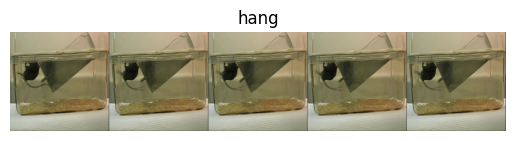

In [3]:
import random

# Load a random training clip and its label
c = Clip(random.choice(train_clips))
frames, label = c.get_data()
c.close()

# Show first five frames
plt.imshow(np.hstack([frames[..., i] for i in range(0, 5)]))
plt.axis('off')
plt.title(label)
plt.show()

## Baseline model

The baseline model works as follows:

- Images are rescaled to be 224 x 224
- An ImageNet pre-trained CNN backbone is used as a feature extractor
- The extracted features are used to train a random forest classifier

No hyperparameter tuning has been performed here - it is simply trained with sklearn defaults.

In [4]:
import tensorflow as tf

backbone = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, c.channels),
    pooling="avg"
)

# backbone.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [6]:
# This function yields a batch of clips of size n.
# Given Google Colab's limited RAM, you may need keep n small
def chunkify(seq, n):

    for i in range(0, len(seq), n):
        yield seq[i:i + n]

print("Running feature extraction...")
X, y = [], []
for chunk in chunkify(train_clips, 64):

    Xc, yc = [], []
    for cp in chunk:  # load clips in current chunk
        clip = Clip(cp)
        frames, label = clip.get_data()
        c.close()

        if frames is not None:
            mid_frame =  frames[..., clip.length // 2]
            if len(mid_frame.shape) == 3:  # no idea why this is happening
                Xc.append(mid_frame)
                yc.append(label)

    # Extract features and append to list
    f_pred = backbone.predict(np.stack(Xc, axis=0))  # default batch size is 32
    X.append(f_pred)
    y.extend(yc)

# Save features
X_all = np.concatenate(X, axis=0)
y_all = np.asarray(y)
print(X_all.shape, y_all.shape)
save_path = Path(dataset_path).parents[0] / "clipped_features.npz"
np.savez(save_path, X_all, y_all)

Running feature extraction...
2/2 [==============================] - 0s 57ms/step
(3563, 1280) (3563,)


Once the features have been extracted and serialised, the features are loaded back in to train a random forest classifier.

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Load features from npz file
save_path = Path(dataset_path).parents[0] / "clipped_features.npz"
data = np.load(save_path)

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(data['arr_0'], data['arr_1'], random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

(2672, 1280) (2672,) (891, 1280) (891,)


# Evaluation

The following code will compute a confusion matrix and accuracy score based on `y_true` and `y_pred`. Accuracy is calculated based by averaging over the accuracies for each individual class (a.k.a. macro-averaged accuracy):

$acc_{macro} = \frac{1}{M} \Sigma_{i=1}^{M} acc_i$

where $acc_i = \frac{TP+TN}{TP+TN+FP+FN}$ for any given class $i$.

You can use this code to carry out your final evaluation. The code should work for both string-encoded and one-hot encoded labels.

0.863986786797447


Text(0.5, 1.0, 'Validation performance')

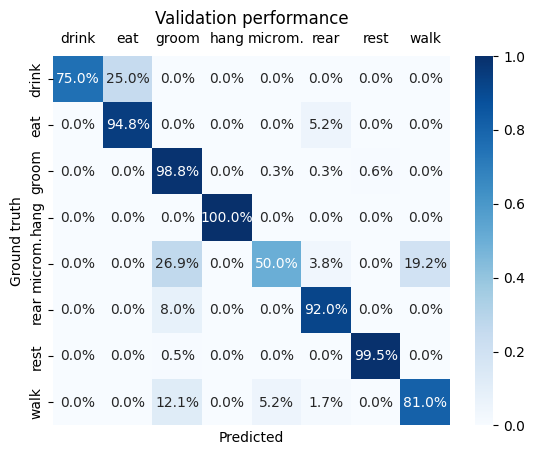

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

axis_labels = LABELS.copy()
axis_labels[4] = "microm." # for readability

def evaluate(y_true, y_pred):

    # Plot confusion matrix
    cf = confusion_matrix(y_true, y_pred, normalize="true")
    s = sns.heatmap(cf, annot=True,
                fmt='.1%', cmap='Blues',
                xticklabels=axis_labels, yticklabels=axis_labels)
    s.set(xlabel="Predicted", ylabel="Ground truth")
    s.tick_params(axis='both', which='major', labelsize=10,
                  labelbottom = False, bottom=False, top = False, labeltop=True)

    # Calculate macro-accuracy
    avg_acc = cf.diagonal().mean()
    print(np.mean(avg_acc))

evaluate(y_val, y_pred)
plt.title("Validation performance")